In [53]:
import pandas as pd
import numpy as np

In [54]:
train_df = pd.read_csv('training.csv')

In [55]:
# txkey全部都是唯一資料，刪除不用
train_df.drop('txkey', axis=1, inplace=True)

## Setup data type

In [56]:
train_df[['chid','cano','contp','etymd','mchno','acqic','mcc','ecfg','insfg','bnsfg',\
          'stocn','scity','stscd','ovrlt','flbmk','hcefg','csmcu','flg_3dsmk','label']] = \
    train_df[['chid','cano','contp','etymd','mchno','acqic','mcc','ecfg','insfg','bnsfg','stocn',\
              'scity','stscd','ovrlt','flbmk','hcefg','csmcu','flg_3dsmk','label']].astype('category')

train_df[train_df.select_dtypes(include='int64').columns] = \
    train_df[train_df.select_dtypes(include='int64').columns].astype('int32')

train_df[train_df.select_dtypes(include='float64').columns] = \
    train_df[train_df.select_dtypes(include='float64').columns].astype('float32')

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8688526 entries, 0 to 8688525
Data columns (total 25 columns):
 #   Column     Dtype   
---  ------     -----   
 0   locdt      int32   
 1   loctm      int32   
 2   chid       category
 3   cano       category
 4   contp      category
 5   etymd      category
 6   mchno      category
 7   acqic      category
 8   mcc        category
 9   conam      float32 
 10  ecfg       category
 11  insfg      category
 12  iterm      float32 
 13  bnsfg      category
 14  flam1      int32   
 15  stocn      category
 16  scity      category
 17  stscd      category
 18  ovrlt      category
 19  flbmk      category
 20  hcefg      category
 21  csmcu      category
 22  csmam      int32   
 23  flg_3dsmk  category
 24  label      category
dtypes: category(19), float32(2), int32(4)
memory usage: 502.4 MB


In [57]:
# Check for missing values
print(train_df.isnull().sum())

locdt              0
loctm              0
chid               0
cano               0
contp              0
etymd         203455
mchno              0
acqic              0
mcc             4550
conam              0
ecfg               0
insfg              0
iterm              0
bnsfg              0
flam1              0
stocn            600
scity         266066
stscd        8665195
ovrlt              0
flbmk              0
hcefg         286656
csmcu         498657
csmam              0
flg_3dsmk          0
label              0
dtype: int64


### Check 'stscd' status code

  stscd        0      1
0   0.0      746     53
1   1.0    11959  10426
2   2.0      132      0
3   3.0        2      0
4   4.0       13      0
5    NA  8643645  21550


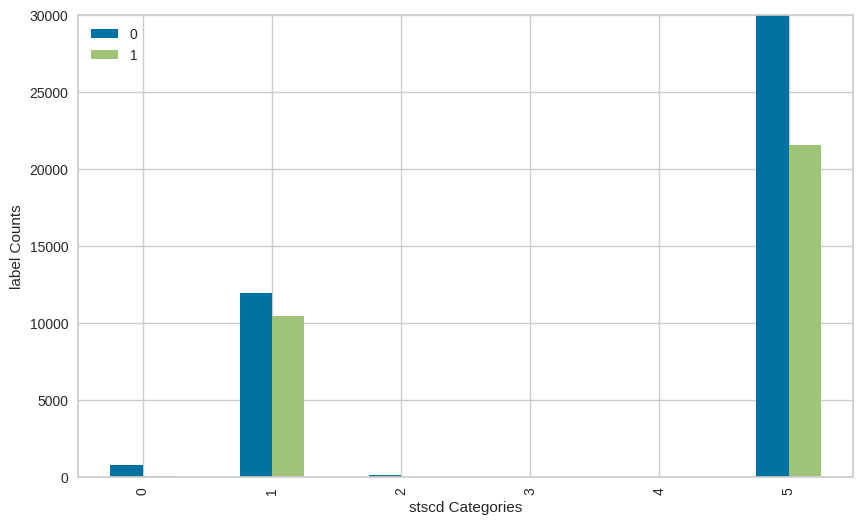

In [58]:
import matplotlib.pyplot as plt
## check stscd data distribution
df = train_df.copy()
df['stscd']=df['stscd'].cat.add_categories("NA").fillna("NA")
stscd_table = df[['label','stscd']].pivot_table(index='stscd', columns='label', aggfunc=len, fill_value=0)
stscd_table = stscd_table.reset_index().rename_axis(None, axis=1).rename_axis(None, axis=0)
print(stscd_table)
stscd_table.plot(kind='bar', stacked=False, figsize=(10, 6)).set_ylim(0, 30000) 
plt.xlabel('stscd Categories')
plt.ylabel('label Counts')
plt.show()

## Add transformed features

In [59]:
# Binary indicator for missing values
train_df['stscd_missing'] = train_df['stscd'].isnull().astype('int32')# should be category
print(train_df['stscd_missing'].value_counts())
train_df['stscd_missing'] = train_df['stscd_missing'].astype('category')

1    8665195
0      23331
Name: stscd_missing, dtype: int64


## Add time series column

In [60]:
train_df['sequence'] = (train_df.sort_values(by=['chid', 'locdt', 'loctm']).groupby('chid').cumcount() + 1).astype('int32')

In [61]:
# 指定要填充的欄位
columns_to_fill = ['etymd', 'mcc', 'stocn', 'scity', 'stscd', 'hcefg', 'csmcu']

# 將 "unknown" 添加到類別中，如果已經存在，則忽略
for column in columns_to_fill:
    train_df[column] = train_df[column].cat.add_categories('-1').fillna('-1')

# Check for missing values
print(train_df.isnull().sum())
print(train_df.info())

locdt            0
loctm            0
chid             0
cano             0
contp            0
etymd            0
mchno            0
acqic            0
mcc              0
conam            0
ecfg             0
insfg            0
iterm            0
bnsfg            0
flam1            0
stocn            0
scity            0
stscd            0
ovrlt            0
flbmk            0
hcefg            0
csmcu            0
csmam            0
flg_3dsmk        0
label            0
stscd_missing    0
sequence         0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8688526 entries, 0 to 8688525
Data columns (total 27 columns):
 #   Column         Dtype   
---  ------         -----   
 0   locdt          int32   
 1   loctm          int32   
 2   chid           category
 3   cano           category
 4   contp          category
 5   etymd          category
 6   mchno          category
 7   acqic          category
 8   mcc            category
 9   conam          float32 
 10  ecfg    

## PyCaret setup

In [62]:
# label轉成數值，不轉會出現error
train_df['label'] = train_df['label'].astype('int64')

In [63]:
# import ClassificationExperiment and init the class
from pycaret.classification import ClassificationExperiment
exp = ClassificationExperiment()

In [64]:
categorical_feature = [col for col in train_df.columns if train_df[col].dtype == 'category' and col != 'label']
print(categorical_feature)
print('Number of categorical feature:', len(categorical_feature))

['chid', 'cano', 'contp', 'etymd', 'mchno', 'acqic', 'mcc', 'ecfg', 'insfg', 'bnsfg', 'stocn', 'scity', 'stscd', 'ovrlt', 'flbmk', 'hcefg', 'csmcu', 'flg_3dsmk', 'stscd_missing']
Number of categorical feature: 19


In [65]:
# init setup on exp
exp.setup(train_df, target='label',
          fix_imbalance=True, fix_imbalance_method='RandomOverSampler',
          n_jobs=8,fold=5,
          log_experiment=True, experiment_name='Exp_1121_add_stscd_time',
          session_id=6996)

,Description,Value
0,Session id,6996
1,Target,label
2,Target type,Binary
3,Original data shape,"(8688526, 27)"
4,Transformed data shape,"(14725654, 59)"
5,Transformed train set shape,"(12119096, 59)"
6,Transformed test set shape,"(2606558, 59)"
7,Ordinal features,7
8,Numeric features,7
9,Categorical features,19


2023/11/21 17:14:10 INFO mlflow.tracking.fluent: Experiment with name 'Exp_1121_add_stscd_time' does not exist. Creating a new experiment.


### LighGBM

In [66]:
LightGBM = exp.create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9986,0.8681,0.7036,0.8961,0.7883,0.7876,0.7934
1,0.9986,0.8526,0.6989,0.8988,0.7864,0.7857,0.7919
2,0.9986,0.8658,0.6920,0.9052,0.7844,0.7837,0.7908
3,0.9986,0.9792,0.6989,0.8967,0.7856,0.7849,0.7910
4,0.9991,0.9783,0.8207,0.9150,0.8653,0.8648,0.8661
Mean,0.9987,0.9088,0.7228,0.9023,0.8020,0.8013,0.8066
Std,0.0002,0.0574,0.0491,0.0071,0.0317,0.0318,0.0297


In [67]:
exp.save_model(LightGBM, 'Exp_1121_add_stscd_time_lightgbm_cv5_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['locdt', 'loctm', 'conam', 'iterm',
                                              'flam1', 'csmam', 'sequence'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean',
                                                               verbose='deprecated'))),
                 ('categorical_imputer',
                  Tra...
                  LGBMClassifier(boosting_type='gbdt', class_weigh

In [68]:
tune_lightgbm = exp.tune_model(LightGBM, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9987,0.9968,0.7067,0.9277,0.8023,0.8016,0.8091
1,0.9987,0.9959,0.7029,0.9235,0.7983,0.7976,0.8051
2,0.9987,0.9948,0.6963,0.9342,0.7979,0.7972,0.8059
3,0.9987,0.9969,0.7038,0.9225,0.7985,0.7978,0.8052
4,0.9990,0.9982,0.7928,0.9314,0.8565,0.8560,0.8588
Mean,0.9988,0.9965,0.7205,0.9279,0.8107,0.8101,0.8168
Std,0.0001,0.0011,0.0363,0.0045,0.0230,0.0230,0.0211


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Info] Number of positive: 4847638, number of negative: 4847638
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.090221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And 

In [69]:
exp.save_model(tune_lightgbm, 'Tuned_1121_add_stscd_time_lightgbm_cv5_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['locdt', 'loctm', 'conam', 'iterm',
                                              'flam1', 'csmam', 'sequence'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean',
                                                               verbose='deprecated'))),
                 ('categorical_imputer',
                  Tra...
                                 boosting_type='gbdt', class_weigh

### RF

In [70]:
RF = exp.create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9988,0.8924,0.6920,0.9637,0.8056,0.8050,0.8161
1,0.9988,0.8903,0.6893,0.9620,0.8032,0.8026,0.8138
2,0.9987,0.8927,0.6855,0.9636,0.8011,0.8005,0.8122
3,0.9987,0.8964,0.6880,0.9590,0.8012,0.8006,0.8117
4,0.9988,0.9113,0.6983,0.9631,0.8096,0.8090,0.8195
Mean,0.9988,0.8966,0.6906,0.9623,0.8041,0.8035,0.8147
Std,0.0000,0.0076,0.0043,0.0018,0.0032,0.0032,0.0029


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warnin

In [71]:
exp.save_model(RF, 'Exp_1121_add_stscd_time_RF_cv5_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['locdt', 'loctm', 'conam', 'iterm',
                                              'flam1', 'csmam', 'sequence'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean',
                                                               verbose='deprecated'))),
                 ('categorical_imputer',
                  Tra...
                  RandomForestClassifier(bootstrap=True, ccp_alpha

In [72]:
tune_RF = exp.tune_model(RF, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9969,0.9919,0.7168,0.5568,0.6268,0.6252,0.6302
1,0.9967,0.9947,0.7114,0.5407,0.6144,0.6128,0.6186
2,0.9967,0.9948,0.7061,0.5370,0.6100,0.6084,0.6141
3,0.9968,0.9939,0.7128,0.5491,0.6203,0.6188,0.6241
4,0.9966,0.9951,0.7181,0.5321,0.6113,0.6096,0.6166
Mean,0.9967,0.9941,0.7130,0.5432,0.6166,0.6150,0.6207
Std,0.0001,0.0012,0.0043,0.0088,0.0062,0.0063,0.0058


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [73]:
exp.save_model(tune_lightgbm, 'Tuned_1121_add_stscd_time_RF_cv5_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['locdt', 'loctm', 'conam', 'iterm',
                                              'flam1', 'csmam', 'sequence'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean',
                                                               verbose='deprecated'))),
                 ('categorical_imputer',
                  Tra...
                                 boosting_type='gbdt', class_weigh

### Evaluate models by public dataset

In [77]:
from sklearn.metrics import classification_report

In [78]:
public_df = pd.read_csv('public.csv')

In [79]:
public_df[['txkey','chid','cano','contp','etymd','mchno','acqic','mcc','ecfg','insfg','bnsfg',\
          'stocn','scity','stscd','ovrlt','flbmk','hcefg','csmcu','flg_3dsmk']] = \
    public_df[['txkey','chid','cano','contp','etymd','mchno','acqic','mcc','ecfg','insfg','bnsfg','stocn',\
              'scity','stscd','ovrlt','flbmk','hcefg','csmcu','flg_3dsmk']].astype('category')

public_df[public_df.select_dtypes(include='int64').columns] = \
    public_df[public_df.select_dtypes(include='int64').columns].astype('int32')

public_df[public_df.select_dtypes(include='float64').columns] = \
    public_df[public_df.select_dtypes(include='float64').columns].astype('float32')

public_df.drop('txkey', axis=1, inplace=True)

# Binary indicator for missing values
public_df['stscd_missing'] = public_df['stscd'].isnull().astype('int32')# should be category

public_df['stscd_missing'] = public_df['stscd_missing'].astype('category')

public_df['sequence'] = (public_df.sort_values(by=['chid', 'locdt', 'loctm']).groupby('chid').cumcount() + 1).astype('int32')

# 指定要填充的欄位
columns_to_fill = ['etymd', 'mcc', 'stocn', 'scity', 'stscd', 'hcefg', 'csmcu']

# 將 "unknown" 添加到類別中，如果已經存在，則忽略
for column in columns_to_fill:
    public_df[column] = public_df[column].cat.add_categories('-1').fillna('-1')

# Check for missing values
print(public_df.isnull().sum())
print(public_df.info())

locdt            0
loctm            0
chid             0
cano             0
contp            0
etymd            0
mchno            0
acqic            0
mcc              0
conam            0
ecfg             0
insfg            0
iterm            0
bnsfg            0
flam1            0
stocn            0
scity            0
stscd            0
ovrlt            0
flbmk            0
hcefg            0
csmcu            0
csmam            0
flg_3dsmk        0
label            0
stscd_missing    0
sequence         0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 609040 entries, 0 to 609039
Data columns (total 27 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   locdt          609040 non-null  int32   
 1   loctm          609040 non-null  int32   
 2   chid           609040 non-null  category
 3   cano           609040 non-null  category
 4   contp          609040 non-null  category
 5   etymd          609040 non-null  cate

In [80]:
X_public = public_df.drop('label', axis=1)
y_public = public_df['label']

In [81]:
predictions = exp.predict_model(tune_lightgbm, data=X_public)
print(classification_report(y_public,predictions['prediction_label'].values))

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    606856
           1       0.86      0.26      0.40      2184

    accuracy                           1.00    609040
   macro avg       0.93      0.63      0.70    609040
weighted avg       1.00      1

In [82]:
predictions = exp.predict_model(tune_RF, data=X_public)
print(classification_report(y_public,predictions['prediction_label'].values))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    606856
           1       0.94      0.26      0.40      2184

    accuracy                           1.00    609040
   macro avg       0.97      0.63      0.70    609040
weighted avg       1.00      1.00      1.00    609040

